# Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import datasets

sns.set()

In [2]:
# load & format iris dataset
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['species'] = [iris.target_names[i] for i in iris.target]

# petal lenghts of each species
setosa_petal_length = iris_df.loc[iris_df['species'] == 'setosa', 'petal length (cm)'].to_numpy()
versicolor_petal_length = iris_df.loc[iris_df['species'] == 'versicolor', 'petal length (cm)'].to_numpy()
virginica_petal_length = iris_df.loc[iris_df['species'] == 'virginica', 'petal length (cm)'].to_numpy()


In [3]:
def ecdf(data):
    """
    returns X and Y arrays 
    for the ECDF of a 1D array of measuremetns.
    """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n   # 1/n to 1 in equally spaced increments
    return x, y

___

# Parameter Estimation

If we believe the process that generates our data follows a given probability distribution, a major goal of statistical inference is to estimate the values of these parameters, which allows us to concisely and unambiguously describe our data and draw conclusions from it. The optimal parameters for the model are directly computed from the data itself.

## Bootstrap Samples

Slight variations in the measured data would lead to slightly different parameters. We can simulate getting new data (i.e. what we would get from an infinitude of experiments) by bootstrapping: resampling our data with replacement and recomputing the parameter(s) of interest.

+ each new sample is called a bootstrap sample.
+ its summary statistics is called a bootstrap replicate.

We can: 

+ plot the ECDF of the bootstrap replicates to get the probability distribution of the parameter.
+ calculate confidence intervals of the statistics. If we repeated measurements over and over again, p% of the observed values would lie within the p% confidence interval.


#### Bootstrap Formulas

In [4]:
def bootstrap_sample_1d(data):
    """Generate bootstrap sample of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return bs_sample

def bootstrap_replicate_1d(bs_sample, func):
    """Generate bootstrap replicate of 1D data."""
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_samples = np.empty((size, len(data)))
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_samples[i, :] = bootstrap_sample_1d(data)
        bs_replicates[i] = bootstrap_replicate_1d(bs_samples[i], func)

    return bs_samples, bs_replicates


## Population Mean

The probability distribution of the sample mean will always be normally distributed if some conditions are met. In this case:
+ mu 
+ standard error of the mean = $\sigma / \sqrt{n}$


In [5]:
# 10,000 bootstrap replicates of the mean
seed = np.random.seed(42)
bs_samples, bs_replicates = draw_bs_reps(versicolor_petal_length, np.mean, size=10000)

# mean and standard deviation of the sampling distribution of the mean
bs_mu = np.mean(bs_replicates) # mean of the mean
bs_std = np.std(bs_replicates) # standard error of the mean


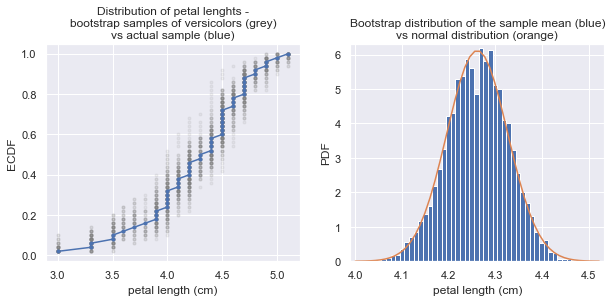

In [6]:
# fig & seed
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (2 * 5, 4))

# plot the ECDF of the first 50 bootstrap samples
for i in range(50):
    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_samples[i, :])
    _ = ax1.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(versicolor_petal_length)
_ = ax1.plot(x, y, marker='.')

# Make a histogram of 10,000 bootstrap replicates of the mean
_ = ax2.hist(bs_replicates, bins=50, normed=True)

# the distribution of the sample mean is normally distributed around the mean
xmin = bs_mu - 4 * bs_std
xmax = bs_mu + 4 * bs_std
x = np.linspace(xmin, xmax, 50)

_ = ax2.plot(x, stats.norm.pdf(x, bs_mu, bs_std))

# Make margins and label axes
plt.margins(0.02)
_ = ax1.set_xlabel('petal length (cm)')
_ = ax1.set_ylabel('ECDF')
_ = ax2.set_xlabel('petal length (cm)')
_ = ax2.set_ylabel('PDF')

# titles
_ = ax1.set_title('Distribution of petal lenghts -\nbootstrap samples of versicolors (grey)\nvs actual sample (blue)')
_ = ax2.set_title('Bootstrap distribution of the sample mean (blue)\nvs normal distribution (orange)')


In [7]:
# compare the theoritical standard error of the mean (SEM) vs from bootstrap replicates
sem = np.std(versicolor_petal_length) / np.sqrt(len(versicolor_petal_length))
bs_std = np.std(bs_replicates)
print('SEM: {:.3} - Bootstraps SD: {:.3}'.format(sem, bs_std))

# confidence intervals
ci = np.percentile(bs_replicates, [2.5, 97.5])
print('95% Confidence Interval: P025 = {:0.2f}, P050 = {:0.2f}, P975 = {:0.2f}'.format(ci[0], bs_replicates.mean(), ci[1]))


SEM: 0.0658 - Bootstraps SD: 0.0652
95% Confidence Interval: P025 = 4.13, P050 = 4.26, P975 = 4.39


## Population Variance

The distribution of the sampling variance:
+ is not normal.
+ is always skewed to the right.
+ has a mean equal to the population variance. 

If the population from which samples are selected follows a normal distribution, the sampling distribution of sample variances [follows a chi-square distribution](https://online.stat.psu.edu/stat414/lesson/26/26.3). Its degrees of freedom are equal to the sample size minus one (n-1) degrees of freedom. If n is large, it can be [approximated](https://www.vosesoftware.com/riskwiki/NormalapproximationtotheChiSquareddistribution.php) by a normal distribution (n-1), sqrt(2 * (n-1)).


In [8]:
# 10,000 bootstrap replicates of the variance
seed = np.random.seed(42)
bs_samples, bs_replicates = draw_bs_reps(versicolor_petal_length, np.var, size=10000)

# mean and standard deviation of the sampling distribution of the variance
bs_mu = np.mean(bs_replicates) # mean of the variance
bs_std = np.std(bs_replicates) # standard error of the variance

# bs_replicates coeff
chi_df = len(versicolor_petal_length) - 1
chi_coeff = chi_df / versicolor_petal_length.var()


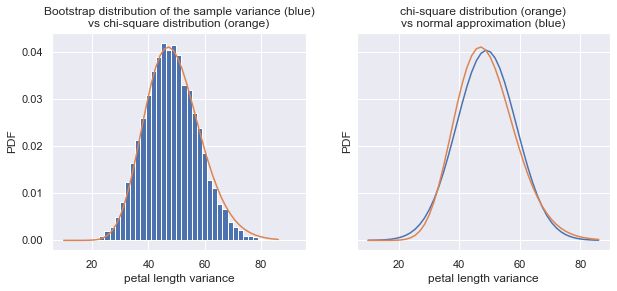

In [9]:
# fig & seed
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (2 * 5, 4), sharey=True)

# Make a histogram of the results
_ = ax1.hist(chi_coeff * bs_replicates, bins=40, density=True, stacked=True)

# chi-square distribution
xmin = bs_mu - 4 * bs_std
xmax = bs_mu + 4 * bs_std
x = np.linspace(chi_coeff * xmin, chi_coeff * xmax, 50)
_ = ax1.plot(x, stats.chi2.pdf(x, chi_df))

# chi vs normal
_ = ax2.plot(x, stats.norm.pdf(x, chi_df, np.sqrt(2*chi_df)))
_ = ax2.plot(x, stats.chi2.pdf(x, chi_df))

# labels
_ = ax1.set_xlabel('petal length variance')
_ = ax1.set_ylabel('PDF')
_ = ax2.set_xlabel('petal length variance')
_ = ax2.set_ylabel('PDF')

# titles
_ = ax1.set_title('Bootstrap distribution of the sample variance (blue)\nvs chi-square distribution (orange)')
_ = ax2.set_title('chi-square distribution (orange)\nvs normal approximation (blue)')


___

# Hypothesis Testing

You now know how to define and estimate parameters of a given model. But the question remains: how reasonable is it that our observed data are actually described by our model? Hypothesis testing is an assessment of how reasonable the observed data are assuming a hypothesis is true; it is called the null hypothesis.

What about the data do we assess, and how do we quantify the assessment? We use a test statistic: a single number that can be computed from observed data and from the data you generate under the null hypothesis. It serves as a basis of comparison between what the null hypothesis predicts and what we actually observed.

_Note: the test statistic should be relevant to the question you are trying to answer._

_Note2: Hypothesis testing is sometimes called Null Hypothesis Significance Testing or NHST._

## Permutation Samples

We could plot ECDFs or compare summary statistics. Another approach when comparing two samples is to combine data from both samples, scramble them and split the results in two samples that have the same size as the original ones. This simulates a null hypothesis where we assume the two quantities are identically distributed. The two resulting samples are called permutation samples.

We can repeat the permutations many times to get the distribution of the difference in test statistics between the two samples under the null hypothesis. We can then calculate the percentatge of permutations that are more extreme than the observed data (i.e. the probability of having data at least as extreme as the observed value under the null hypothesis): the p-value.

The p-value is NOT the probability that the null hypothesis is true, and is only valid if both the null hypothesis and the test statistic used to evaluate it are clearly stated.

If the p-value is small (typically under 5%), the data is considered statistically significantly different than what we would observe under the null hypothesis.


#### Permutation Formulas

In [10]:
def permutation_sample(data_1, data_2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data_1, data_2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]

    return perm_sample_1, perm_sample_2


def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_samples_1 = np.empty((size, len(data_1)))
    perm_samples_2 = np.empty((size, len(data_2)))
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_samples_1[i, :], perm_samples_2[i, :] = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_samples_1[i, :], perm_samples_2[i, :])

    return perm_samples_1, perm_samples_2, perm_replicates


def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff


## Permutation Test

Permutation test check if two samples follow the same distribution. In this example, we want to check if the petal length of versicolor and virginica are identically distributed.

We conduct the test as follows:
+ the null hypothesis states that versicolor and virginica have the same petal length distribution. 
+ our test statistic is the difference in means. 
+ we want to calculate the probability of getting a difference in mean petal length at least as extreme as our samples if H0 is true.

We use permutations samples to calculate the probability distribution of the test statistic (difference in means) under the null hypothesis.

In [11]:
# ECDF of petal length of two species
x_vers, y_vers = ecdf(versicolor_petal_length)
x_virg, y_virg = ecdf(virginica_petal_length)

# difference in mean petal length from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(versicolor_petal_length, virginica_petal_length)

# permutation samples
seed = np.random.seed(42)
perm_samples_1, perm_samples_2, perm_replicates = draw_perm_reps(versicolor_petal_length, virginica_petal_length, diff_of_means, size=10000) 


The mean petal length of the two species are very different:

In [12]:
print('Mean petal length: {:0.2}cm for Versicolor - {:0.2}cm for Virginica'.format(versicolor_petal_length.mean(), virginica_petal_length.mean()))

Mean petal length: 4.3cm for Versicolor - 5.6cm for Virginica


The graph on the left shows that the ECDFs of permutation samples overlap and give a purple haze. None of them overlap with the observed data: Versicolor and Virginica petal lengths do not appear to be identically distributed.

The graph on the right shows the probability distribution of our test statistic under H0 and the observed data (difference in means of 1.3 cm); observing the data under H0 seems very unlikely. 

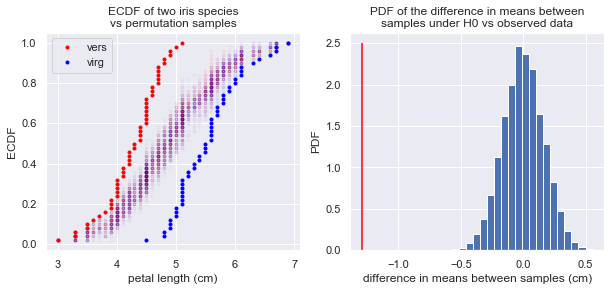

In [13]:
# fig & seed
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (2 * 5, 4))

for i in range(50):

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_samples_1[i, :])
    x_2, y_2 = ecdf(perm_samples_2[i, :])

    # Plot ECDFs of permutation sample
    _ = ax1.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
    _ = ax1.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)

# Create and plot ECDFs from original data
_ = ax1.plot(x_vers, y_vers, marker='.', linestyle='none', color='red', label = 'vers')
_ = ax1.plot(x_virg, y_virg, marker='.', linestyle='none', color='blue', label = 'virg')
_ = ax1.legend()

# distribution of the test statistic (diff in means)
_ = ax2.hist(perm_replicates, bins=20, normed=True)
_ = ax2.vlines(empirical_diff_means, 0, 2.5, color='red')

# labels
_ = ax1.set_xlabel('petal length (cm)')
_ = ax1.set_ylabel('ECDF')
_ = ax2.set_xlabel('difference in means between samples (cm)')
_ = ax2.set_ylabel('PDF')


# titles
_ = ax1.set_title('ECDF of two iris species\nvs permutation samples')
_ = ax2.set_title('PDF of the difference in means between\nsamples under H0 vs observed data')


The chance of observing a difference in means at least as extreme as the observed data under H0, the p-value, is 0. We can reject the null hypothesis.

In [14]:
# Compute p-value: p
p = np.sum(perm_replicates <= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)


p-value = 0.0


## Two Samples Bootstrap Hypothesis Test

Permutation tests check if two samples have the same distribution. We can test if they have the same mean but not necessarily the same distribution.

We conduct the test as follows:
+ the null hypothesis states that versicolor and virginica have the same mean petal length. 
+ our test statistic is the diffein rence mean. 
+ we want to calculate the probability of getting a difference in means at least as extreme as our samples if H0 is true.

We use bootstrap samples of modified version of our samples: we shift their values so that their means matches H0.

In [15]:
# means
mean_vers = versicolor_petal_length.mean()
mean_virg = virginica_petal_length.mean()
shared_mean = np.concatenate((versicolor_petal_length, virginica_petal_length)).mean()

# Generate shifted arrays
vers_shifted = versicolor_petal_length - mean_vers + shared_mean
virg_shifted = virginica_petal_length - mean_virg + shared_mean

# compute 10,000 bootstrap replicates from the shifted arrays
seed = seed = np.random.seed(42)
_, bs_replicates_vers = draw_bs_reps(vers_shifted, np.mean, 10000)
_, bs_replicates_virg = draw_bs_reps(virg_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
obs_diff = mean_virg - mean_vers
bs_replicates = bs_replicates_virg - bs_replicates_vers


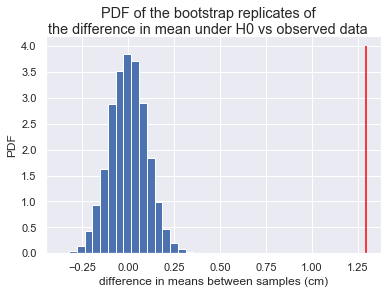

In [20]:
# show histogram
_ = plt.hist(bs_replicates, bins=20, normed=True)
_ = plt.vlines(np.mean(obs_diff), 0, 4, color='red')
_ = plt.xlabel('difference in means between samples (cm)')
_ = plt.ylabel('PDF')
_ = plt.suptitle('PDF of the bootstrap replicates of\nthe difference in mean under H0 vs observed data')


In [16]:
# Compute and print p-value: p
p = sum(bs_replicates >= obs_diff) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0


## One-Sample Bootstrap Hypothesis Test

We can also compare the parameter of interest of a given sample with a fixed value. In this example, we have access to the versicolor sample and the mean petal length of virginica.

We conduct the test as follows:
+ the null hypothesis states that versicolor and virginica have the same mean petal length. 
+ our test statistic is the mean. 
+ we want to calculate the probability of getting a mean petal length at least as extreme as our versicolor sample if H0 is true.

We use bootstrap samples of a modified version of the versicolor sample: we shift its values so that its mean matches H0.

In [17]:
# means
mean_vers = versicolor_petal_length.mean()
mean_virg = virginica_petal_length.mean()

# Generate shifted array
vers_shifted = versicolor_petal_length - mean_vers + mean_virg

# compute 10,000 bootstrap replicates from the shifted array
seed = seed = np.random.seed(42)
_, bs_replicates_vers = draw_bs_reps(vers_shifted, np.mean, 10000)

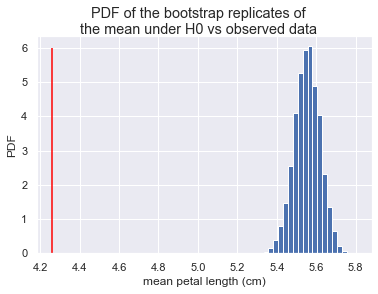

In [18]:
# show histogram
_ = plt.hist(bs_replicates_vers, bins=20, normed=True)
_ = plt.vlines(mean_vers, 0, 6, color='red')
_ = plt.xlabel('mean petal length (cm)')
_ = plt.ylabel('PDF')
_ = plt.suptitle('PDF of the bootstrap replicates of\nthe mean under H0 vs observed data')


In [19]:
# Compute and print p-value: p
p = sum(bs_replicates_vers <= mean_vers) / len(bs_replicates_vers)
print('p-value =', p)

p-value = 0.0
